In [1]:
import itertools
import operator
import sys
import os
from collections import defaultdict
import numpy as np
from tqdm import tqdm
sys.path.append("../src")
from glob import glob
import pandas as pd
import json
from matplotlib import pyplot as plt


In [44]:
search_root = "/checkpoint/jth/neuraldb/final=true/experiment=entire_database/dataset=ndb,model=t5-base,version=v0.5/lr=5e-4/context=50,filters=null,max_queries=null/"
checkpoint_name = "*test*ssg*.json"
files = glob("{}*/**/{}".format(search_root,checkpoint_name), recursive=True)

print(len(files))


10


In [45]:
def expand(idx,chunk):
  #elif idx == 1:
  #  return ["experiment={}".format(chunk)]
  if chunk.startswith("seed-"):
    return ["seed={}".format(chunk.replace("seed-",""))]
  elif "," in chunk:
    return chunk.split(",")
  elif "=" in chunk:
    return [chunk]
  return []

experiments = []
for file in files:

    chunks = file.split("/")
    chunks = itertools.chain(*[expand(idx, chunk) for idx, chunk in enumerate(chunks)])

    data = {k:v for k,v in (chunk.split("=") for chunk in chunks)}
    data["file"] = file
    data["fname"] = os.path.basename(file)
    data['dir'] = os.path.dirname(file)
    data['context'] = int(data['context'])
    if "pipeline" in data:
        data["experiment"] = data["experiment"] + " " + data["pipeline"]

    experiments.append(data)

In [51]:
to_remove = []
for idx, experiment in enumerate(tqdm(experiments[::-1])):
    all_raw = []
    all_breakdown = defaultdict(dict)
    all_breakdown_strict = defaultdict(dict)

    with open(experiment['file']) as f:
        for line in f.readlines()[-4:]:
            if line[0] == "}":
                line = line[1:]
            try:
                partial_results = json.loads(line)

            except Exception as e:

                continue

            all_raw.extend(partial_results['test']['raw'])
            all_breakdown["breakdown_prop"].update(partial_results['test']['breakdown']["relation_type"].items())
            all_breakdown["breakdown_type"].update(partial_results['test']['breakdown']["query_type"].items())

            all_breakdown_strict["breakdown_prop"].update(partial_results['test']['strict_breakdown']["relation_type"].items())
            all_breakdown_strict["breakdown_type"].update(partial_results['test']['strict_breakdown']["query_type"].items())


    if len(all_raw) == 0 or experiment["experiment"] == "oracle_concat":
        to_remove.append(idx)

    experiment["EM"] = np.mean([rec[2] for rec in all_raw])
    experiment["EM_strict"] = np.mean([rec[3] for rec in all_raw])

    for k,v in all_breakdown["breakdown_prop"].items():
        experiment["prop_{}".format(k)] = np.mean(v)

    for k,v in all_breakdown["breakdown_type"].items():
        experiment["type_{}".format(k)] = np.mean(v)
        experiment["count_type_{}".format(k)] = len(v)

    for k,v in all_breakdown_strict["breakdown_type"].items():
        experiment["type_strict_{}".format(k)] = np.mean(v)

    questions = defaultdict(list)
    for q in all_raw:
        questions [q[4]["qnum"]].append(q)


    a_em = 0
    a_cnt = 0
    for qnum, partials in questions.items():


        expected_answer = partials[0][1]
        predicted_answers = [partial[0] for partial in partials]

        query_type = partials[0][4]["query_type"]
        if expected_answer == "[NULL_ANSWER]":
            a_cnt +=1
            if any(a==expected_answer for a in predicted_answers):
                a_em += 1
        elif query_type  in {"min/max","set","count"}:
            expecteds = [a.strip() for a in expected_answer.split("[LIST]")]
            predicteds = [[a.strip() for a in ans.split("[LIST]")] for ans in predicted_answers]
            all_predicted = set()
            for p in predicteds:
                all_predicted.update(p)


        else: # not in {"min/max","set","count"}:
            a_cnt +=1
            if any(a==expected_answer for a in predicted_answers):
                a_em += 1




    experiment["A_EM"] = a_em/a_cnt
    experiment["raw"] = all_raw

print(len(experiments))

100%|██████████| 10/10 [00:03<00:00,  3.16it/s]


10


In [52]:
results = pd.DataFrame(experiments).fillna(0)
results = results[(results["lr"] == "5e-4")]
print(len(results))
cols = {col:[np.mean, np.std] for col in filter(lambda col: col == "A_EM" or col == "EM" or col == "EM_strict" or col.startswith("type_"),results.columns)}
breakdown_cols = list(filter(lambda col: col.startswith("prop_"),results.columns))
query_cols = list(filter(lambda col: col.startswith("type_"),results.columns))

breakdown = pd.pivot_table(results, index=["experiment","fname","model","context"],aggfunc=cols)
breakdown.to_csv("results_oracle.csv")
print(len(breakdown_cols))
breakdown

10
17


A_EM  \
                                                                                        mean   
experiment      fname                                              model   context             
entire_database metrics_test_dev_queries_last_50_st_ssg_distant... t5-base 50       0.567396   
                metrics_test_dev_queries_last_50_st_ssg_supervi... t5-base 50       0.508626   

                                                                                              \
                                                                                         std   
experiment      fname                                              model   context             
entire_database metrics_test_dev_queries_last_50_st_ssg_distant... t5-base 50       0.054760   
                metrics_test_dev_queries_last_50_st_ssg_supervi... t5-base 50       0.047345   

                                                                                          EM  \
                                                                                        mean   
experiment      fname                                              model   context             
entire_database metrics_test_dev_queries_last_50_st_ssg_distant... t5-base 50       0.262493   
                metrics_test_dev_queries_last_50_st_ssg_supervi... t5-base 50       0.349051   

                                                                                              \
                                                                                         std   
experiment      fname                                              model   context             
entire_database metrics_test_dev_queries_last_50_st_ssg_distant... t5-base 50       0.019970   
                metrics_test_dev_queries_last_50_st_ssg_supervi... t5-base 50       0.031434   

                                                                                   EM_strict  \
                                                                                        mean   
experiment      fname                                              model   context             
entire_database metrics_test_dev_queries_last_50_st_ssg_distant... t5-base 50       0.258732   
                metrics_test_dev_queries_last_50_st_ssg_supervi... t5-base 50       0.343768   

                                                                                              \
                                                                                         std   
experiment      fname                                              model   context             
entire_database metrics_test_dev_queries_last_50_st_ssg_distant... t5-base 50       0.019858   
                metrics_test_dev_queries_last_50_st_ssg_supervi... t5-base 50       0.031349   

                                                                                   type_atomic_boolean  \
                                                                                                  mean   
experiment      fname                                              model   context                       
entire_database metrics_test_dev_queries_last_50_st_ssg_distant... t5-base 50                 0.283693   
                metrics_test_dev_queries_last_50_st_ssg_supervi... t5-base 50                 0.539802   

                                                                                              \
                                                                                         std   
experiment      fname                                              model   context             
entire_database metrics_test_dev_queries_last_50_st_ssg_distant... t5-base 50       0.036326   
                metrics_test_dev_queries_last_50_st_ssg_supervi... t5-base 50       0.054048   

                                                                                   type_atomic_extractive  \
                                                                                 

In [47]:
for exp in experiments:
    if exp["experiment"] == "pipeline":
        e = filter(lambda item: item[4]["query_type"] == "set" and item[3] < 0.5,  exp["raw"])

        for result in e:
            print(result)

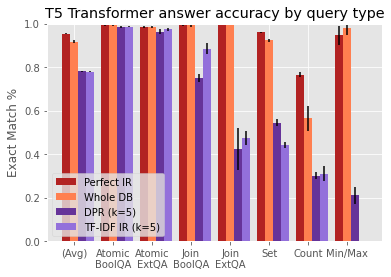

In [63]:
models = set(idx[0] for idx in breakdown.index)
lookup = {
    "EM":"(Avg)",
    "type_set":"Set",
          "type_count": "Count",
          "type_strict_min/max": "Min/Max",
          "type_join_boolean": "Join\nBoolQA",
          "type_strict_join_extractive": "Join\nExtQA",
          "type_atomic_boolean": "Atomic\nBoolQA",
          "type_strict_atomic_extractive":"Atomic\nExtQA"}

lookup2 = {
    "entire_database":"Whole DB",
    "oracle_large":"Perfect IR",
    "search_database": "TF-IDF IR (k=5)",
    "search_database_large": "TF-IDF IR (k=50)",
    "pipeline dpr": "DPR (k=5)",
    "pipeline big_dpr": "DPR (k=50)"
}


def doplot(model,count, cols=query_cols):
    means = []
    std = []

    for col in cols:
        means.append(breakdown[col]["mean"].T[model]["t5-base"][count])
        std.append(breakdown[col]["std"].T[model]["t5-base"][count])

    plt.figure(figsize=(5,4))
    plt.xticks(rotation=90)


    plt.title(f"Scores for queries over database with {count} facts {model}")
    plt.xlabel("Query Type")
    plt.ylabel("Exact Match %")
    plt.ylim(0,1)
    plt.bar([lookup[col] if col in lookup else col for col in cols], means, yerr=std)
    plt.tight_layout()

    return plt

def doplot_cmp(models, count, cols=query_cols):
    x = np.arange(len(cols))
    w = 1/(len(models)+1)
    plt.xticks(x+w, [lookup[col] if col in lookup else col for col in cols],rotation=0)
    plt.ylabel("Exact Match %")
    colors = ["firebrick", "coral","rebeccapurple", "mediumpurple", "darkcyan","skyblue"]
    for idx, model in enumerate(models):
        means = []
        std = []
        for col in cols:

            means.append(breakdown[col]["mean"].T[model]["t5-base"][count])
            std.append(breakdown[col]["std"].T[model]["t5-base"][count])


        plt.bar(x+idx*w,means,yerr=std, width=w, color=colors[idx])

    plt.ylim(0,1)
    plt.legend([lookup2[m] for m in models], loc='lower left', )# bbox_to_anchor=(1,-0.6))

    return plt

import matplotlib.pyplot as plt
with plt.style.context("ggplot"):
    # plt = doplot("oracle_concat",50, ["EM","query_atomic_boolean",
    #                                   "query_atomic_extractive",
    #                                   "query_join_boolean",
    #                                   "query_join_extractive",
    #                                   "query_set",
    #                                   "query_count",
    #                                   "query_min/max"
    #                                   ])

    plt = doplot_cmp([
        "oracle_large",
        "entire_database",
        #"pipeline big_dpr",
        "pipeline dpr",
        #"search_database_large",
        "search_database"
    ],50, ["EM","type_atomic_boolean",
                                  "type_strict_atomic_extractive",
                                  "type_join_boolean",
                                  "type_strict_join_extractive",
                                  "type_set",
                                  "type_count",
                                  "type_strict_min/max"
                                  ])

    plt.title("T5 Transformer answer accuracy by query type")

    plt.savefig("/checkpoint/jth/neuraldb/t5_baselines.pdf")
    plt.show()



In [ ]:
with plt.style.context("ggplot"):
    for model in models:

        for count in breakdown["EM"]["mean"].T[model]["t5-base"].index:
            plt = doplot(model,count)
            plt.show()


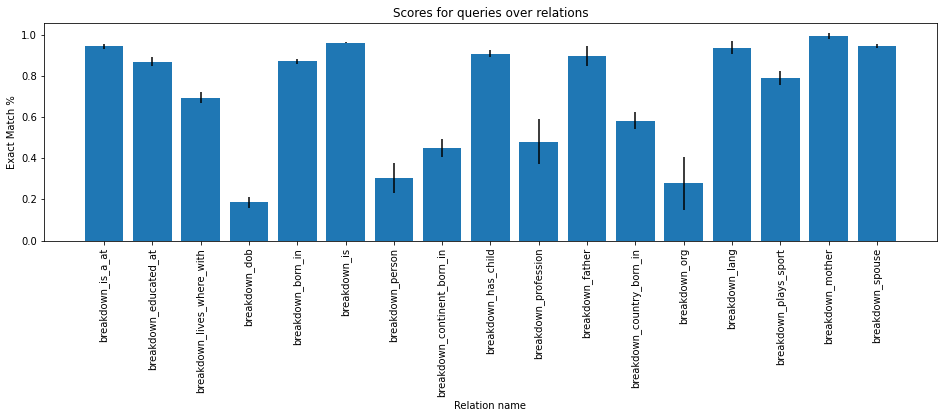

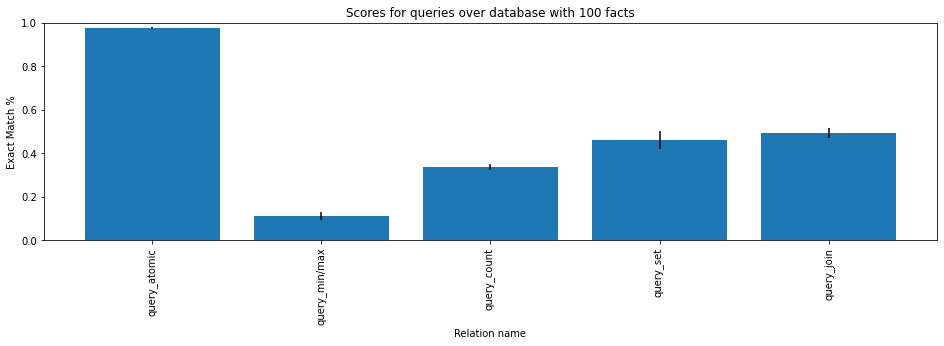

In [51]:

means = []
std = []

for col in breakdown_cols:

    means.append(breakdown[col]["mean"].T[model]["t5-base"]["100"])
    std.append(breakdown[col]["std"].T[model]["t5-base"]["100"])

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)

plt.title("Scores for queries over relations")
plt.xlabel("Relation name")
plt.ylabel("Exact Match %")

plt.bar(breakdown_cols, means, yerr=std)
plt.show()


means = []
std = []

for col in query_cols:

    means.append(breakdown[col]["mean"].T[model]["t5-base"]["100"])
    std.append(breakdown[col]["std"].T[model]["t5-base"]["100"])

plt.figure(figsize=(16,4))
plt.xticks(rotation=90)
plt.ylim(0,1)

plt.title("Scores for queries over database with 100 facts")
plt.xlabel("Relation name")
plt.ylabel("Exact Match %")

plt.bar(query_cols, means, yerr=std)
plt.show()